In [6]:
import pyvisa as visa
import time
import numpy as np
from pymeasure.instruments.keithley import Keithley2400
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from UtilsBasic import *
from UtilsKeithley6221 import *
import telnet as tn
import pyvisa

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

import pylab as pl
from IPython import display
N = 100000 # minimum digit 10uA
import datetime
print(datetime.datetime.now())
#from field_control import vsm_set_field, set_field, read_field
import os
rm = visa.ResourceManager()
rm.list_resources()

def connect(address, name=None, logs=None):
    rm = visa.ResourceManager()
    if address is None:
        return None
    else:
        try:
            if not name:
                device = rm.open_resource(address)
                if logs:
                    logs.add("{}:  {}".format(address, device.query("*IDN?").strip()))

                print(device.query("*IDN?"))
            else:
                device = Keithley2400(address)
                if logs:
                    logs.add("{}:  {}".format(address, device.id.strip()))

                print(device.id)
                # check connection
            return device
        except Exception as e:
            if logs:
                logs.add("error: {}".format(e))
            print(e)
            return None

from UtilsPPMS import *
#ppms = Dynacool('192.168.0.7')
# # ppms.setField(0)
# # ppms.setTemperature(300)
# # ppms.waitForField()
# # ppms.waitForTemperature()
# switch=tn.telnet('192.168.0.8')

2023-04-24 11:51:53.356815


In [7]:
def plotPPMSSwitch(file_name):
    #Plot current data
    hlength = 0
    with open(file_name) as myFile:
        for num, line in enumerate(myFile, 1):
            if 'pulsed' in line:
                hlength = num-1
            if 'fields (Oe):' in line:
                measfieldsstr=line.split(':')[1].split(',')
                measfields=[int(x) for x in measfieldsstr]
            if 'switch ports:' in line:
                switchports=line.split(':')[1].split('\n')[0].split(',')
            if 'measurement names:' in line:
                measnames=line.split(':')[1].split('\n')[0].split(',')
                if len(measnames) != len(switchports):
                    measnames=switchports

    df = pd.read_csv(file_name, header=hlength)
    #print(df)
    plt.clf()
    numswitches=len(switchports)
    for measname in measnames:
        cols = [label for label in df.columns if any(x in label for x in [measname+'_V', 'angle','field', 'temp','dc_current','pulsed'])]
        sdf=df[cols]
        satdf=sdf[sdf['field(Oe)']!=0]
        remdf=sdf[sdf['field(Oe)']==0]
        pulseddf=remdf[remdf['pulsed']==1]
        remdf=remdf[remdf['pulsed']==0]
        fig,ax=plt.subplots()

        plt.suptitle(file_name.split('/')[-1][:-4]+'_'+measname)
    
        ax.plot(satdf['angle(deg)'],satdf.iloc[:,5]/satdf.iloc[:,4], linestyle='-',marker='o',color='g',markersize=3,linewidth=1,label=satdf.columns[5]+' saturated')
        ax.plot(remdf['angle(deg)'],remdf.iloc[:,5]/remdf.iloc[:,4], linestyle='-',marker='o',color='b',markersize=3,linewidth=1,label=satdf.columns[5]+' remnant')
        ax.plot(pulseddf['angle(deg)'],pulseddf.iloc[:,5]/pulseddf.iloc[:,4], linestyle='-',marker='o',color='r',markersize=3,linewidth=1,label=satdf.columns[5]+' pulsed')

#         df0=sdf[sdf['pulsed']==0]
#         df1=sdf[sdf['pulsed']==1]
#         ax.plot(df0.iloc[:,i+3]/df0.iloc[:,2], linestyle='',color='b',marker='o',markersize=4,label='_nolegend_')
#         ax.plot(df1.iloc[:,i+3]/df1.iloc[:,2], linestyle='',color='r',marker='o',markersize=4,label='_nolegend_')
        ax.ticklabel_format(useOffset=False)
        ax.set_xlabel('pulse count')
        ax.set_ylabel('$\Omega$')

        plt.tick_params(direction='in', which='both', right=True, top=True)
        #plt.tick_params(which='major', length=6)
        #plt.tick_params(which='minor', length=3)
        plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
        plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
        #plt.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        plt.rcParams['font.family'] = "Arial"    
        ax.legend()
        fig.savefig(file_name[:-4]+'_'+measname+'.png', dpi=600)
def plotPPMSSwitchCurAr(file_name):
    #Plot current data
    hlength = 0
    with open(file_name) as myFile:
        for num, line in enumerate(myFile, 1):
            if 'pulse_current' in line:
                hlength = num-1
            if 'fields (Oe):' in line:
                measfieldsstr=line.split(':')[1].split(',')
                measfields=[int(x) for x in measfieldsstr]
            if 'switch ports:' in line:
                switchports=line.split(':')[1].split('\n')[0].split(',')
            if 'measurement names:' in line:
                measnames=line.split(':')[1].split('\n')[0].split(',')
                if len(measnames) != len(switchports):
                    measnames=switchports

    df = pd.read_csv(file_name, header=hlength)
    #print(df)
    plt.clf()
    numswitches=len(switchports)
    for measname in measnames:
        cols = [label for label in df.columns if any(x in label for x in [measname+'_V', 'angle', 'temp','dc_current','field','pulse_current'])]
        sdf=df[cols]
        fig,ax=plt.subplots()

        plt.suptitle(file_name.split('/')[-1][:-4]+'_'+measname)
    

        for key, ssdf in sdf.groupby(['angle(deg)']):
            #print(ssdf)
            ax.plot(ssdf.iloc[:,0],ssdf.iloc[:,5]/ssdf.iloc[:,4], linestyle='-',marker='o',markersize=3,linewidth=1, label=ssdf.columns[5]+'_{:.0f}deg'.format(key))

        ax.ticklabel_format(useOffset=False)
        ax.set_xlabel('pulse current (A)')
        ax.set_ylabel('$\Omega$')
        plt.tick_params(direction='in', which='both', right=True, top=True)
        #plt.tick_params(which='major', length=6)
        #plt.tick_params(which='minor', length=3)
        plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
        plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
        #plt.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        plt.rcParams['font.family'] = "Arial"    
        ax.legend()
        fig.savefig(file_name[:-4]+'_'+measname+'.png', dpi=600)
#plotPPMSSwitchCurAr('./data/PPMS_switch/LSC699_Au(80)_Cr(5)_Pt(1.9)_Fe2O3(15)_Al2O3(0001)_3x3_6W1.7L/0319_1656_ppms_switchTest.csv')
#plotPPMSSwitch('./data/PPMS_switch/XE329A_Au(80)_Cr(5)_Pt(2.5)_Fe2O3(1h)_Al2O3(0001)/0418_2207_switch_5degstep_2p3e12.csv')

In [8]:
dc_2400_id = 25
nanovolt_id = 17
ac_6221_id=14

dc = Keithley2400("GPIB::{}".format(dc_2400_id))
volt = rm.open_resource('GPIB0::{}::INSTR'.format(nanovolt_id))
#ac=K6221(GPIBnum=ac_6221_id)
#switch=tn.telnet('192.168.0.8')
#ppms = Dynacool('192.168.0.7')

def measure_resistance(dc, volt, dc_current=100e-6, measure_points=30, skip_points=5, time_per_point=0.1):
    dc.apply_current()  # Sets up to source current
    dc.source_current_range = 10e-3   # Sets the source current range to 10 mA
    dc.compliance_voltage = 20        # Sets the compliance voltage to 10 V
    dc.source_current = dc_current            # Sets the source current to 0 mA
    dc.enable_source() 
    time.sleep(6)
    v_up = []
    for i in range(30):  # apply positive current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_up.append(float(volt.query("fetch?")))
    v_up = sorted(v_up)
    v_up = v_up[3: -3]
    dc.source_current = -1 * dc_current
    dc.enable_source() 
    
    v_down = []
    for i in range(measure_points):   # apply negative current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_down.append(float(volt.query("fetch?")))
    
    dc.shutdown() 
    
    v_down = sorted(v_down)
    v_down = v_down[3: -3]
    
    average_v = (np.array(v_up).mean() - np.array(v_down).mean())/2
    std_v = (np.array(v_up).std() + np.array(v_down).std())/2
    return average_v, std_v

def PPMSSwitchRot(angles, switchports, pulseports, sample_id='',dc_current=1e-4, pulse_current_density=1e11, pulse_dur=5e-6, 
                  wait_after_hall=1, wait_after_trigger=1, satfield=10000, cycles=1, reps=1, note='', dc=dc,volt=volt, 
                  ac=ac, ppms=ppms, switch=switch, longnote='', set_temp=300, channel_csas=[], measnames=[]):
    '''
    Function to perform pulse switching with a Kietheley 6221 at various angles in the PPMS. Supports use of the LinkBone
    8x8 matrix switch so that multiple patterns can be measured simultaneously. Stores data at saturation field, 0 field,
    and after pulsing.
    '''
    
    #First close all switch connections
    switch.sendCommand('reset')
    #Set PPMS temperature and wait for it to reach it
    ppms.setTemperature(set_temp)
    print('waiting for temperature...')
    ppms.waitForTemperature()
    
    #Optionally wait more for the rotator shaft to equilibrate
    #time.sleep(300)
    
    #Define datafile name. Includes the local time.
    name = "data/PPMS_switch/"+sample_id+"/{}_{}".format(time.strftime("%m%d_%H%M", time.localtime()),note)
    file_name = name+".csv"
    
    #Creates folder for sample id if none exists.
    try:
        os.mkdir("data/PPMS_switch/"+sample_id)
    except OSError:
        pass
    
    # Define the device column names. If they are provided in a list of the correct length, use provided names.
    if len(measnames)==len(switchports):
        colnames=measnames
    else:
    #Otherwise use the switch ports as the name.
        colnames=switchports

    fullcolnames=[]
    #The full column name is of the format: <user defined name or switch ports>_<V or std_V>
    for colname in colnames:
        for x in ['V','std_V']:
            fullcolnames.append('{}_{}'.format(colname,x))

    # If Cross Sectional Areas of the channels are provided (and the list is the right length), use these to calculate
    # the pulse currents. 
    if len(channel_csas)==len(switchports):
        csas=channel_csas
    else:
    #Otherwise use a default CSA (1e-14m^2 is equivilant to a 5um wide, 2nm thick Pt channel): 
        csa_default=1e-14
        csas=[csa_default]*len(switchports)
        
    with open(file_name, 'a') as f:
        # Write the header of the datafile, which should include all options for the experiment
        f.write("sample id:{}\nnote:{}\ndc current(A):{}\npulse current density(A/m^2):{}\npulse duration(s):{}\nwait after hall(s):{}\nwait after trigger(s):{}\ncycles:{}\nreps:{}\nswitch ports:{}\npulse ports:{}\nsaturating field (Oe):{}\ntemp(K):{}\nchannel cross sectional areas (m^2):{}\nmeasurement names:{}\n".format(
            sample_id,longnote,dc_current,pulse_current_density,pulse_dur,wait_after_hall,wait_after_trigger,cycles,reps,','.join(switchports),','.join(pulseports),satfield,set_temp,','.join([str(x) for x in csas]),','.join(colnames)))
        # Write the column names of datafile
        f.write("pulsed,field(Oe),angle(deg),temp(K),dc_current(A),{}\n".format(','.join(fullcolnames)))
        
    for angle in angles:
        # For each angle, first set the rotator position and wait for it, then read the position.
        ppms.setPosition(angle)
        print('setting angle...')
        ppms.waitForPosition()
        ang=ppms.getPosition()
        
        for c in range(cycles):
            # for each switching cycle, set the saturating field first.
            ppms.setField(satfield)
            print('ramping to saturation field...')
            ppms.waitForField()
            time.sleep(1)
            # set 'pulsed' flag to zero after we orient spins
            pulsed=0
            print('field aligned measurement...')
            readfield=ppms.getField()[1]
            readtemp=ppms.getTemperature()[1]
            vlist=[]
            for switchport in switchports:
                switch.sendCommand('on {},{}'.format(switchport[0],switchport[1]))
                time.sleep(0.5)
                print('reading resistance of {},{}...'.format(switchport[0],switchport[1]))
                average_v,std_v=measure_resistance(dc,volt,dc_current=dc_current)
                vlist.append(average_v)
                vlist.append(std_v)
                time.sleep(wait_after_hall)
                switch.sendCommand('reset')

            with open(file_name, 'a') as f:
                f.write('{},{},{},{},{},{}\n'.format(pulsed,satfield,angle,readtemp,dc_current,','.join(str(x) for x in vlist)))
            display.clear_output(wait=True)
            plotPPMSSwitch(file_name)
            plt.show()
            # Then ramp the field to zero.
            ppms.setField(0)
            print('ramping to 0 field...')
            ppms.waitForField()
            display.clear_output(wait=True)
            for r in range(reps):
            # do the measurement points after field ramp
                print('field aligned remnant measurement...')
                readfield=ppms.getField()[1]
                readtemp=ppms.getTemperature()[1]
                vlist=[]
                for switchport in switchports:
                    switch.sendCommand('on {},{}'.format(switchport[0],switchport[1]))
                    time.sleep(0.5)
                    print('reading resistance of {},{}...'.format(switchport[0],switchport[1]))
                    average_v,std_v=measure_resistance(dc,volt,dc_current=dc_current)
                    vlist.append(average_v)
                    vlist.append(std_v)
                    time.sleep(wait_after_hall)
                    switch.sendCommand('reset')
        
                with open(file_name, 'a') as f:
                    f.write('{},{},{},{},{},{}\n'.format(pulsed,0,angle,readtemp,dc_current,','.join(str(x) for x in vlist)))
                display.clear_output(wait=True)
                plotPPMSSwitch(file_name)
                plt.show()
                
            for r in range(reps):
            # now send pulses and measure
                print('pulse aligned measurement...')
                pulsed=1
                for i in range(len(pulseports)):
                    pulseport=pulseports[i] 
                    csa=csas[i]
                    switch.sendCommand('on {},{}'.format(pulseport[0],pulseport[1]))
                    time.sleep(0.5)
                    print('sending pulse to {},{}...'.format(pulseport[0],pulseport[1]))
                    print(pulse_current_density*csas[i]*1000)
                    ac.pulseOut(amp=pulse_current_density*csas[i],duration=pulse_dur)
                    time.sleep(1)
                    switch.sendCommand('reset')

                time.sleep(wait_after_trigger)
                    
                readfield=ppms.getField()[1]
                readtemp=ppms.getTemperature()[1]
                
                vlist=[]
                for switchport in switchports:
                    switch.sendCommand('on {},{}'.format(switchport[0],switchport[1]))
                    time.sleep(0.5)
                    print('reading resistance of {},{}...'.format(switchport[0],switchport[1]))
                    average_v,std_v=measure_resistance(dc,volt,dc_current=dc_current)
                    vlist.append(average_v)
                    vlist.append(std_v)
                    time.sleep(wait_after_hall)
                    switch.sendCommand('reset')
        
                with open(file_name, 'a') as f:
                    f.write('{},{},{},{},{},{}\n'.format(pulsed,0,angle,readtemp,dc_current,','.join(str(x) for x in vlist)))
                display.clear_output(wait=True)
                plotPPMSSwitch(file_name)
                plt.show()

def PPMSSwitchRotCurAr(angles, switchports, pulseports, sample_id='',dc_current=1e-4, pulse_currents=[1e-3,2e-3], 
                       pulse_dur=5e-6, wait_after_hall=2, wait_after_trigger=10, satfield=10000, note='', dc=dc,volt=volt, 
                       ac=ac, ppms=ppms, switch=switch, longnote='', set_temp=300, measnames=[]):
    switch.sendCommand('reset')
    ppms.setTemperature(set_temp)
    print('waiting for temperature...')
    ppms.waitForTemperature()
    #time.sleep(300)
    name = "data/PPMS_switch/"+sample_id+"/{}_{}".format(time.strftime("%m%d_%H%M", time.localtime()),note)
    file_name = name+".csv"
    try:
        os.mkdir("data/PPMS_switch/"+sample_id)
    except OSError:
        pass
    
    with open(file_name, 'a') as f:
        f.write("sample id:{}\nnote:{}\ndc current(A):{}\npulse duration(s):{}\nwait after hall(s):{}\nwait after trigger(s):{}\nswitch ports:{}\npulse ports:{}\nsaturating field (Oe):{}\ntemp(K):{}\nmeasurement names:{}\n".format(
            sample_id,longnote,dc_current,pulse_dur,wait_after_hall,wait_after_trigger,','.join(switchports),','.join(pulseports),satfield,set_temp,','.join(measnames)))
        if len(measnames)==len(switchports):
            colnames=measnames
        else:
            colnames=switchports
        fullcolnames=[]
        for colname in colnames:
            for x in ['V','std_V']:
                fullcolnames.append('{}_{}'.format(colname,x))
        f.write("pulse_current(A),field(Oe),angle(deg),temp(K),dc_current(A),{}\n".format(','.join(fullcolnames)))
        
    for angle in angles:
        ppms.setPosition(angle)
        print('setting angle...')
        ppms.waitForPosition()
        ang=ppms.getPosition()
        ppms.setField(satfield)
        print('ramping to saturation field...')
        ppms.waitForField()
        time.sleep(1)
        ppms.setField(0)
        print('ramping to 0 field...')
        ppms.waitForField()
        display.clear_output(wait=True)
        for pulse_current in pulse_currents:
        # now send pulses and measure
            print('pulse aligned measurement...')
            for pulseport in pulseports:
                switch.sendCommand('on {},{}'.format(pulseport[0],pulseport[1]))
                time.sleep(0.5)
                print('sending pulse to {},{}...'.format(pulseport[0],pulseport[1]))
                ac.pulseOut(amp=pulse_current,duration=pulse_dur)
                time.sleep(3)
                switch.sendCommand('reset')

            time.sleep(wait_after_trigger)
            readfield=ppms.getField()[1]
            readtemp=ppms.getTemperature()[1]

            vlist=[]
            for switchport in switchports:
                switch.sendCommand('on {},{}'.format(switchport[0],switchport[1]))
                time.sleep(0.5)
                print('reading resistance of {},{}...'.format(switchport[0],switchport[1]))
                average_v,std_v=measure_resistance(dc,volt,dc_current=dc_current)
                vlist.append(average_v)
                vlist.append(std_v)
                time.sleep(wait_after_hall)
                switch.sendCommand('reset')

            with open(file_name, 'a') as f:
                f.write('{},{},{},{},{},{}\n'.format(pulse_current,readfield,angle,readtemp,dc_current,','.join(str(x) for x in vlist)))
            display.clear_output(wait=True)
            plotPPMSSwitchCurAr(file_name)
            plt.show()
            
        
        

<Figure size 640x480 with 0 Axes>

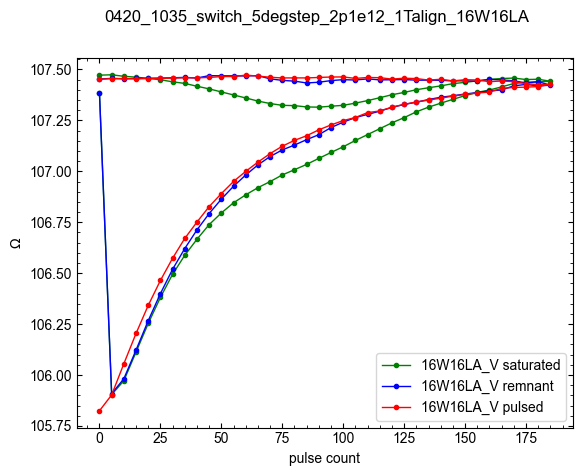

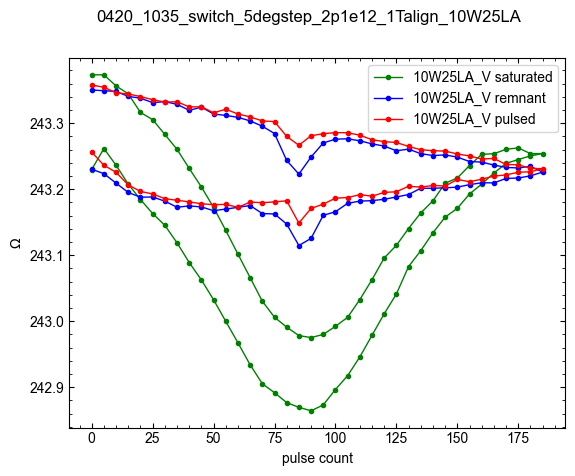

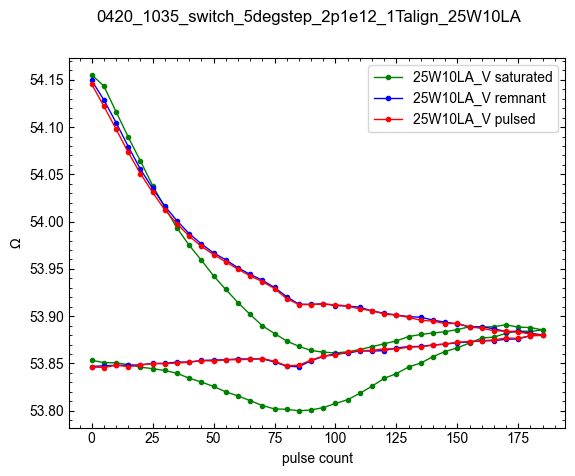

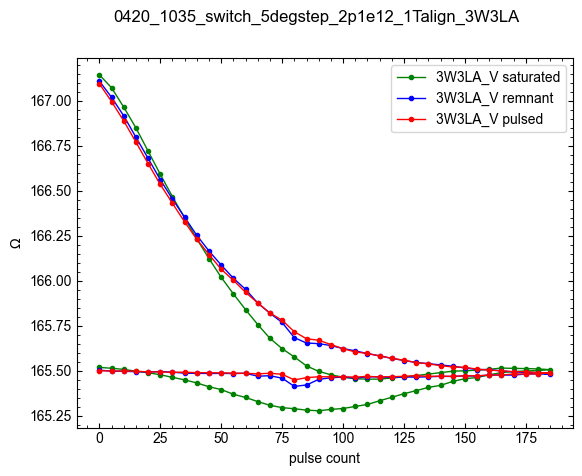

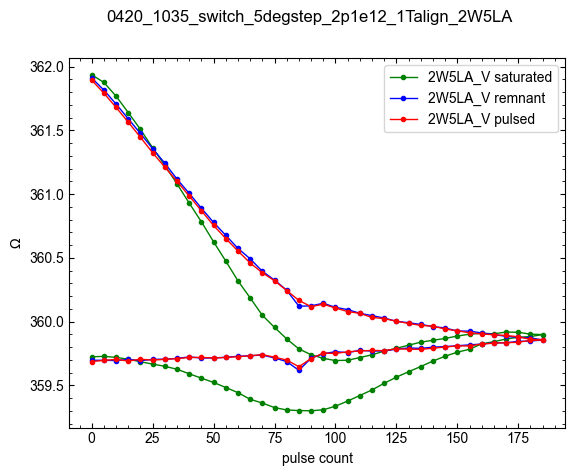

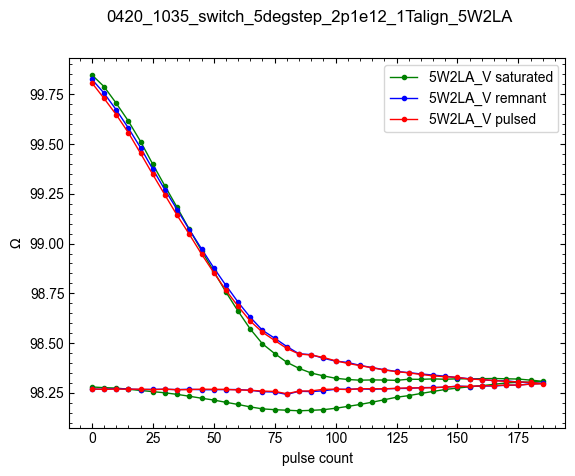

In [12]:
switch=tn.telnet('192.168.0.8')
sample_id='XE330A_Au(80)_Cr(5)_Pt(2.5)_Fe2O3(30min)_Al2O3(0001)'
pulse_current_density=2.1e12
pulse_dur=5e-6
angles=createArraywithSteps([0,185,0],[5,-5])
satfield=10000
switchports=['ma','mb','mc','md','me','mf']
measnames=['16W16LA','10W25LA','25W10LA','3W3LA','2W5LA','5W2LA']
channel_csas=[2.5e-9*15.8e-6,2.5e-9*10e-6,2.5e-9*25e-6,2.5e-9*3.33e-6,2.5e-9*2e-6,2.5e-9*5e-6]
pulseports=['pa','pb','pc','pd','pe','pf']
note='switch_5degstep_2p1e12_1Talign'
longnote='''Check last Fe2O3 thickness. Start from same settings as previous sample.
-'''
PPMSSwitchRot(angles, switchports, pulseports, sample_id=sample_id,dc_current=1e-4, pulse_current_density=pulse_current_density, pulse_dur=pulse_dur, 
                  wait_after_hall=2, wait_after_trigger=1, satfield=satfield, cycles=1, reps=1, note=note, dc=dc,volt=volt, 
                  ac=ac, ppms=ppms, switch=switch, longnote=longnote, set_temp=300, measnames=measnames,channel_csas=channel_csas)

<Figure size 640x480 with 0 Axes>

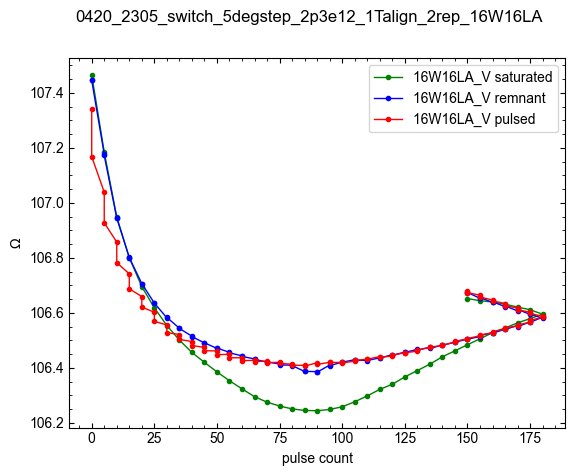

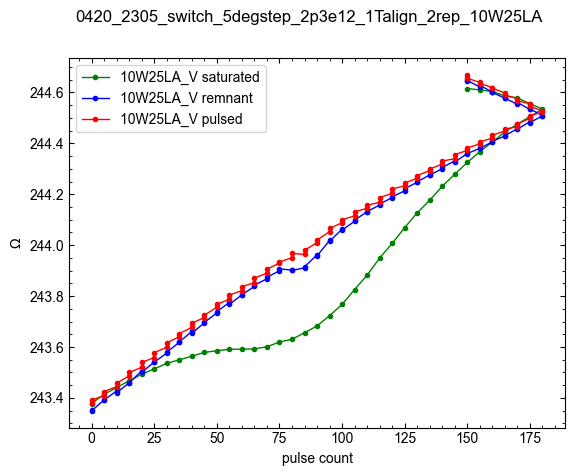

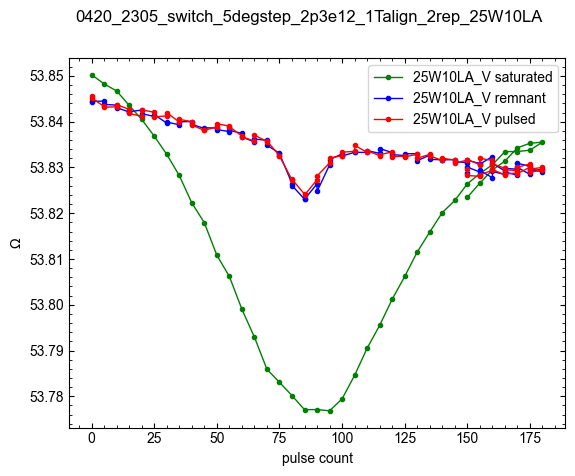

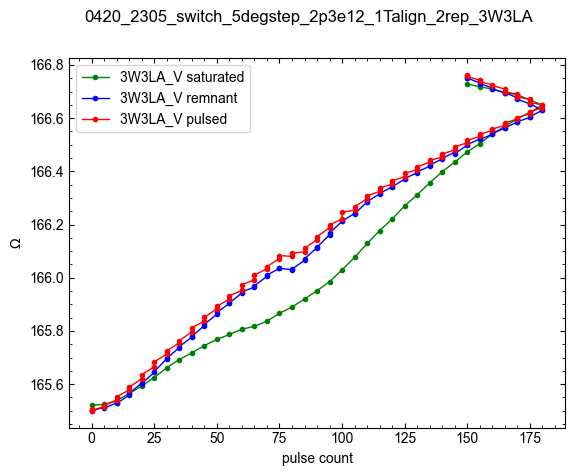

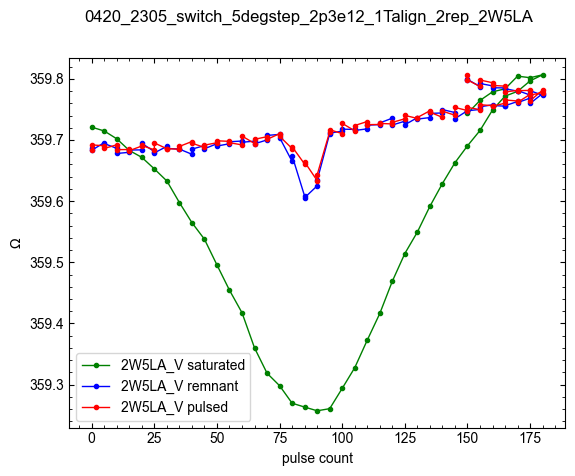

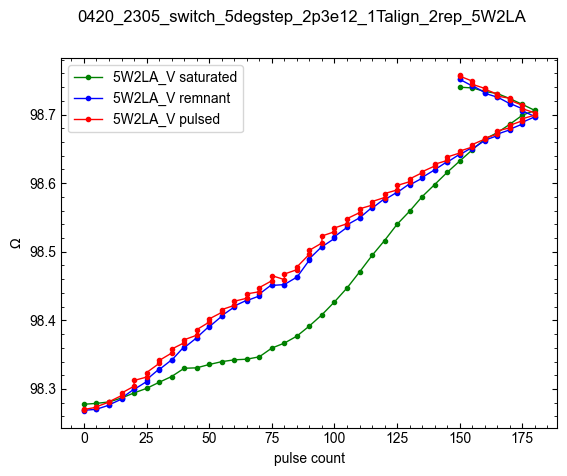

setting angle...
ramping to saturation field...


KeyboardInterrupt: 

In [5]:
switch=tn.telnet('192.168.0.8')
sample_id='XE330A_Au(80)_Cr(5)_Pt(2.5)_Fe2O3(30min)_Al2O3(0001)'
pulse_current_density=2.3e12
pulse_dur=5e-6
angles=createArraywithSteps([0,180,0],[5,-5])
satfield=10000
switchports=['ma','mb','mc','md','me','mf']
measnames=['16W16LA','10W25LA','25W10LA','3W3LA','2W5LA','5W2LA']
channel_csas=[2.5e-9*15.8e-6,2.5e-9*10e-6,2.5e-9*25e-6,2.5e-9*3.33e-6,2.5e-9*2e-6,2.5e-9*5e-6]
pulseports=['pa','pb','pc','pd','pe','pf']
note='switch_5degstep_2p3e12_1Talign_2rep'
longnote='''Check last Fe2O3 thickness. Start from same settings as previous sample.
-'''
PPMSSwitchRot(angles, switchports, pulseports, sample_id=sample_id,dc_current=1e-4, pulse_current_density=pulse_current_density, pulse_dur=pulse_dur, 
                  wait_after_hall=2, wait_after_trigger=1, satfield=satfield, cycles=1, reps=2, note=note, dc=dc,volt=volt, 
                  ac=ac, ppms=ppms, switch=switch, longnote=longnote, set_temp=300, measnames=measnames,channel_csas=channel_csas)

<Figure size 640x480 with 0 Axes>

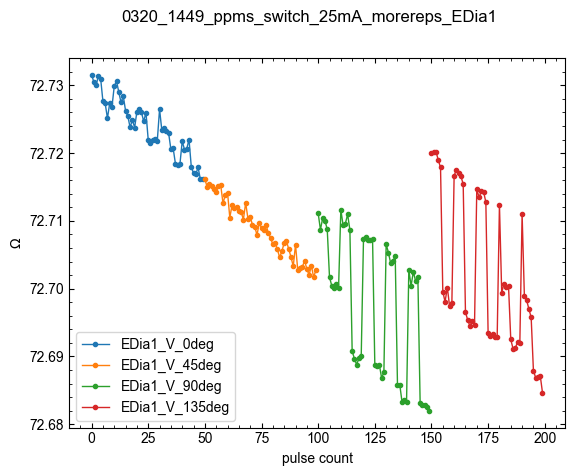

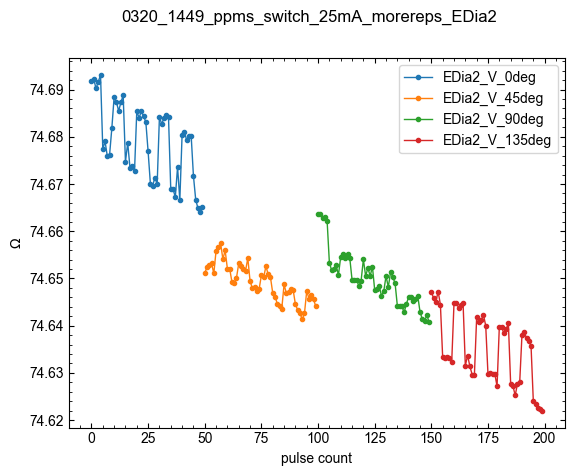

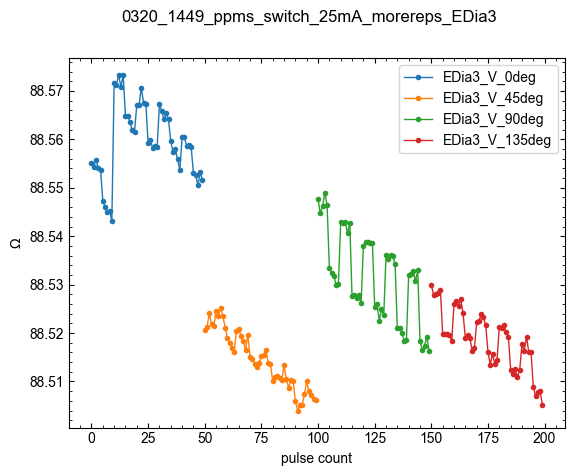

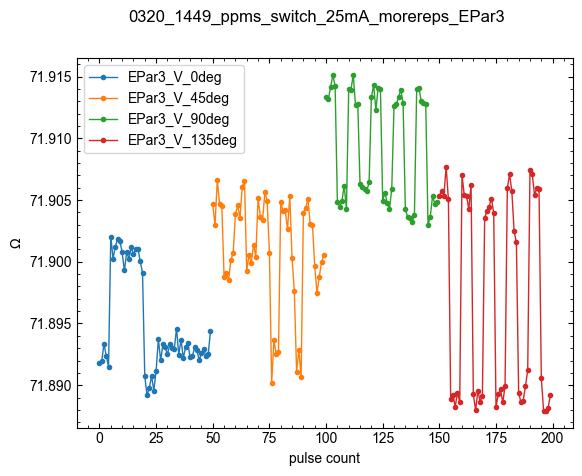

In [113]:
#switch=tn.telnet('192.168.0.8')
sample_id='LSC699_Au(80)_Cr(5)_Pt(1.9)_Fe2O3(15)_Al2O3(0001)_3x3_6W1.7L'
pulse_current=25e-3
pulse_dur=5e-6
angles=[0,45,90,135]
satfield=6000
switchports=['pa','pb','pc','pd']
measnames=['EDia1','EDia2','EDia3','EPar3']
pulseports=['ma', 'mb', 'mc', 'md']
note='ppms_switch_25mA_morereps'
longnote='''more detailed test
testing repeated switch with 25mA for various angles
-'''
PPMSSwitchRot(angles, switchports, pulseports, sample_id=sample_id,dc_current=1e-4, pulse_current=pulse_current, pulse_dur=pulse_dur, 
                  wait_after_hall=2, wait_after_trigger=10, satfield=satfield, cycles=5, reps=5, note=note, dc=dc,volt=volt, 
                  ac=ac, ppms=ppms, switch=switch, longnote=longnote, set_temp=300, measnames=measnames)

<Figure size 640x480 with 0 Axes>

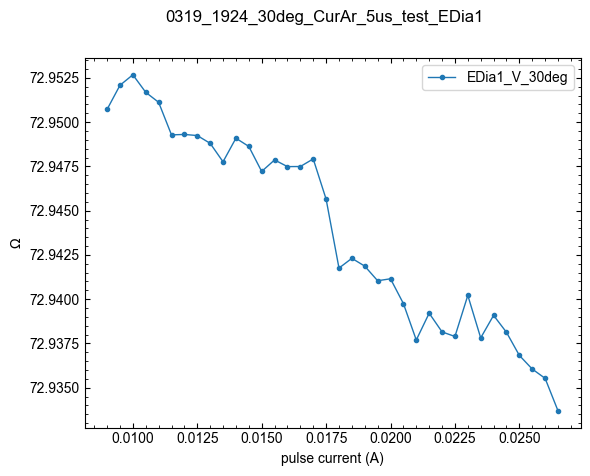

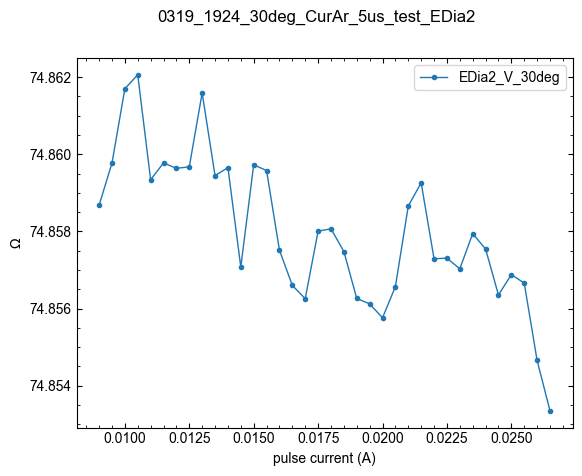

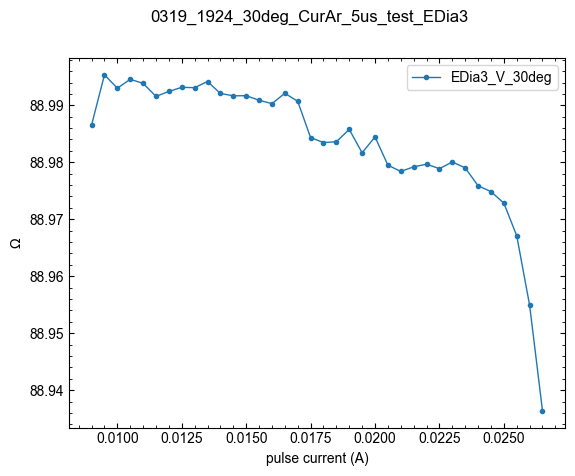

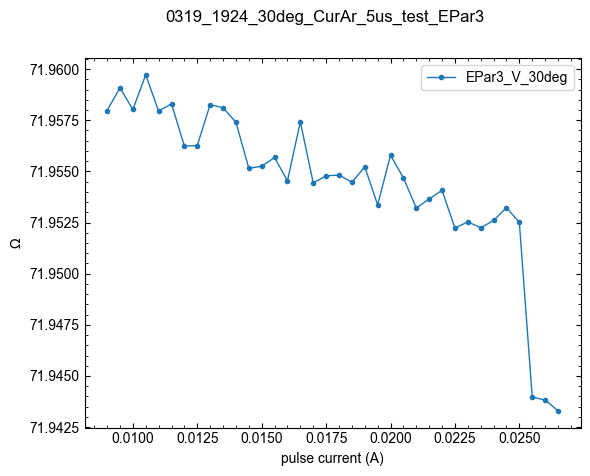

pulse aligned measurement...


KeyboardInterrupt: 

In [109]:
#switch=tn.telnet('192.168.0.8')
sample_id='LSC699_Au(80)_Cr(5)_Pt(1.9)_Fe2O3(15)_Al2O3(0001)_3x3_6W1.7L'
angles=[30]
satfield=10000
pulse_currents=createArraywithSteps([9e-3,30e-3],[0.5e-3])
switchports=['pa','pb','pc','pd']
measnames=['EDia1','EDia2','EDia3','EPar3']
pulseports=['ma', 'mb', 'mc', 'md']
note='30deg_CurAr_5us_test'
longnote='''testing first switching current array.
-'''
PPMSSwitchRotCurAr(angles, switchports, pulseports, sample_id=sample_id,dc_current=1e-4, pulse_currents=pulse_currents, 
                       pulse_dur=5e-6, wait_after_hall=2, wait_after_trigger=10, satfield=satfield, note=note, dc=dc,volt=volt, 
                       ac=ac, ppms=ppms, switch=switch, longnote=longnote, set_temp=300, measnames=measnames)

## List connected devices

In [5]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('ASRL3::INSTR', 'GPIB0::14::INSTR', 'GPIB0::15::INSTR', 'GPIB0::17::INSTR')

## Keithley 6221 AC current source
Connects to the 6221 and first outputs a pulse, followed by a sine wave

In [7]:
from UtilsKeithley6221 import *

#Test Keithley 6221 connection. If it cannot connect, check the GPIB port (specify with K6221(GPIBnum=#))
ac=K6221(GPIBnum=14)
#Output a 10uA pulse
ac.pulseOut(amp=1e-3,duration=5e-6)
#Output a 10uA indefinite length sine wave
#ac.sinOut()

## SR865A Lock-In Amplifier 
Connects to and reads the Lock in parameters

In [31]:
from UtilsSR865A import *
lock=Lockin()
lock.readLockin()

(6.5432664087e-07, -1.3170010789e-06, 1.2890700418e-06, -127.38214111)

In [32]:
from UtilsBasic import *
createArraywithSteps([1,10],[2])

The final array generated is  [1, 3, 5, 7, 9, 10]


[1, 3, 5, 7, 9, 10]